In [1]:
import shapely
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr
import pointCollection as pc
import pyproj
import h5py


In [2]:
#%matplotlib widget


In [3]:
import lxml.etree
import numpy as np
import shapely.geometry
# compile xml parsers for lxml
XMLparser = lxml.etree.XMLParser(recover=True, remove_blank_text=True)
# PURPOSE: parse xml header file and create shapely polygon
def parse_xml_file(xml_file, XMLparser):
    # read xml file and create lxml tree for parsing
    with open(xml_file, 'r') as fid:
        tree = lxml.etree.parse(fid,XMLparser)
    root = tree.getroot()
    LinearRing = root.findall('.//gml:Polygon/gml:exterior/gml:LinearRing/gml:posList', root.nsmap)
    # create a polygon for each linear ring
    poly_list = []
    for ring in LinearRing:
        coords = np.array(ring.text.split(),dtype='f')
        lon,lat = (coords[0:-1:2],coords[1::2])
        poly_list.append(shapely.geometry.Polygon(np.c_[lon, lat]))
    # create shapely polygon
    return shapely.geometry.MultiPolygon(poly_list)

Here's the polygon in lat/lon.  Looks OK.

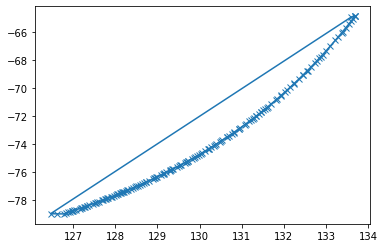

In [4]:
thefile='/home/besmith4/shared/ATL11_processing/Antarctic_testing/001/ATL11_018510_0307_003_01.h5.iso.xml'
P=parse_xml_file(thefile, XMLparser)
lonlat=[]
plt.figure(); 
for poly in P:
    lonlat+=[np.c_[[[c[1], c[0]] for c in P[0].exterior.coords]]]
    plt.plot(lonlat[-1][:,0], lonlat[-1][:,1], marker='x');


Here's how it looks in EPSG 3031.  If you zoom in on the middle, the long connector looks like it intersects the arc of actual coordinates.

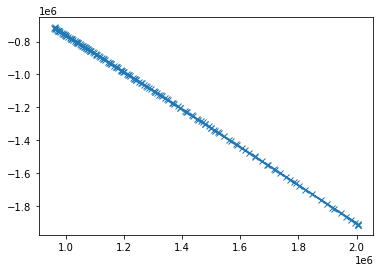

In [5]:
xy=pyproj.Transformer.from_crs(4326, 3031).transform(lonlat[0][:,1], lonlat[0][:,0])
plt.figure(); plt.plot(xy[0], xy[1],marker='x')

Here's that zoom:

(-1800000.0, -1500000.0)

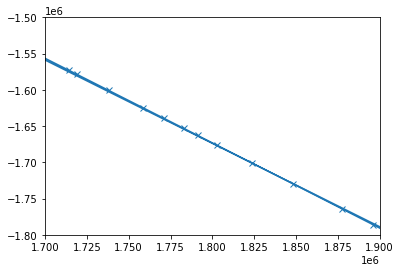

In [11]:
plt.figure(); plt.plot(xy[0], xy[1],marker='x')
plt.gca().set_xlim([1.7e6, 1.9e6])
plt.gca().set_ylim([-1.8e6, -1.5e6])

My way forward is to pull the coordinates from the ATL11 into shapely:

In [12]:

lonlat_11=[]
with h5py.File(thefile.replace('.h5.iso.xml','.h5'),'r') as h5f:
    for pair in ['pt1', 'pt2', 'pt3']:
        try:
            lonlat_11 += [np.c_[h5f[pair+'/longitude'], h5f[pair+'/latitude']]]
        except Exception as e:
            print(e)
xy_11=[]
xformer=pyproj.Transformer.from_crs(4326, 3031)
for ll in lonlat_11:
    xy_11 += [np.c_[xformer.transform(ll[:,1], ll[:,0])]]


Make the xy coordinates of the pair tracks into a shapely collection of lines:

In [13]:
lines=[]
for xx in xy_11:
    lines += [shapely.geometry.LineString(xx)]

Simplify the lines, and buffer them to a resolution of 3 km.  This gives us a single polygon with (in this case) 75 points

In [14]:
line_simp=[]
for line in lines:
    line_simp += [line.simplify(tolerance=100)]
all_lines=shapely.geometry.MultiLineString(line_simp)
common_buffer=all_lines.buffer(3000, 4)
len(common_buffer.exterior.coords.xy[0])

75

We can simplify the polygon further to take out some of the scallops on the ends:

In [15]:
common_buffer=common_buffer.simplify(tolerance=500)
len(common_buffer.exterior.coords.xy[0])

25

Here's the final result:

(904486.6757418079,
 2060457.9724727776,
 -1978324.3909951053,
 -649617.1384369332)

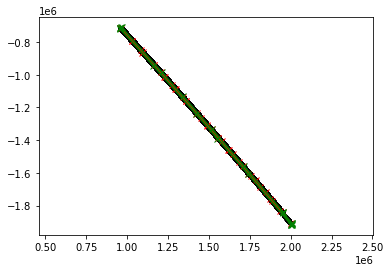

In [16]:
plt.figure(); 
for xy in xy_11:
    plt.plot(xy[:,0], xy[:,1],'k.')
for line in all_lines:
    plt.plot(line.xy[0], line.xy[1], 'r', marker='x')
plt.plot(common_buffer.exterior.coords.xy[0], common_buffer.exterior.coords.xy[1],'g',marker='x')
plt.axis('equal')

And here's a zoom in on the bottom end:

(-1920000.0, -1825000.0)

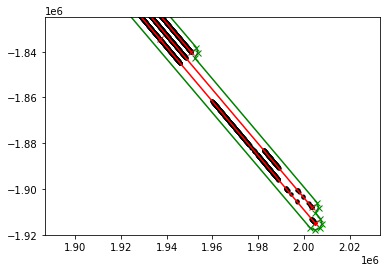

In [19]:
plt.figure(); 
for xy in xy_11:
    plt.plot(xy[:,0], xy[:,1],'k.')
for line in all_lines:
    plt.plot(line.xy[0], line.xy[1], 'r', marker='x')
plt.plot(common_buffer.exterior.coords.xy[0], common_buffer.exterior.coords.xy[1],'g',marker='x')
plt.axis('equal')

plt.gca().set_xlim([1.9e6, 2.02e6])
plt.gca().set_ylim([-1.92e6, -1.825e6])